# Classificação status com movimentacoes,  CNN e RNN - V1

We have combined a pre-trained Word2Vec, RNN and CNN for classification.

## Setup

In [5]:
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(42)

In [36]:
import random
import pandas as pd
import numpy as np
import re
import pickle
import unidecode
import time
import matplotlib.pyplot as plt
import seaborn as sns
import copy 
from random import choice
import time

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.similarities.index import AnnoyIndexer
from gensim.models.phrases import Phrases, Phraser
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model
from keras import optimizers
from keras.regularizers import l1
from keras.models import Sequential
from keras.layers import Flatten,RNN,LSTM,GRU, Conv1D,Dense, TimeDistributed,GlobalMaxPooling1D
from keras.constraints import unit_norm
from keras.regularizers import l2
from keras import regularizers
from itertools import product

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/felipe_polo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preparing

Opening Word2Vec pre-trained model:

In [7]:
word = KeyedVectors.load("modelos/doc2vec_mov_100_5_V5")

W0127 07:34:49.547258 140692720502528 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


In [8]:
embed_dim=np.shape(word['juiz'])[0]
embed_dim

100

Our vocabulary:

In [9]:
word_vectors = word.wv

Stopwords:

In [10]:
stop_words = set(stopwords.words('portuguese')) 

Function for embedding (normalized):

In [11]:
def emb(s):
    return(word[s]/np.sqrt(word[s]@word[s]))

## Preparing dataset

In [12]:
with open("bases/mov.txt", "rb") as fp:   # Legal proceedings
    mov = pickle.load(fp)

with open("bases/tags.txt", "rb") as fp:   # Tags
    tags = pickle.load(fp)

Opening models that identify combinations of words as unique tokens:

In [13]:
bigrams=Phrases.load('modelos/bigrams_mov')
bibigrams=Phrases.load('modelos/bibigrams_mov')

W0127 07:34:59.365389 140692720502528 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead
W0127 07:35:04.385917 140692720502528 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


Letting motions in cronological order:

In [14]:
mov[0][:4]

[['14-11-2018',
  'Tipo do Movimento:Ato Ordinatório Praticado Descrição:Certifico e dou fé que as custas pendentes de fls 685 não foram recolhidas pelas parte GILMAR RODRIGUES REGO e BRUNO MEDEIROS.'],
 ['23-07-2018',
  'Tipo do Movimento:Juntada - Petição Descrição da juntada:Documento eletrônico juntado de forma automática.'],
 ['16-07-2018',
  'Tipo do Movimento:Publicado\xa0 Atos da Serventia Folhas do DJERJ.:388/416'],
 ['29-06-2018', 'Tipo do Movimento:Enviado para publicação ']]

In [15]:
for m in mov:
    m.reverse()

In [16]:
mov[0][:4]

[['10-09-2010',
  'Tipo do Movimento:Distribuição Sorteio Serventia:Cartório da 34ª Vara Cível - 34ª Vara Cível'],
 ['21-09-2010',
  'Tipo do Movimento:Conclusão ao Juiz Juiz:JOAO MARCOS DE CASTELLO BRANCO FANTINATO'],
 ['23-09-2010',
  'Tipo do Movimento:Despacho - Proferido despacho de mero expediente Descrição:Defiro JG. \r\n\r\nIndefiro a antecipação dos efeitos da tutela, eis que as alegações do autor carecem de dilação probatória.\r\n\r\nCite-se.'],
 ['23-09-2010', 'Tipo do Movimento:Enviado para publicação ']]

Defining functions we will use:

In [17]:
#Function that cleans texts:
def clean(resulta):   
    import copy 
   
    result = copy.deepcopy(resulta)
    
    result=result.lower()
    result=re.sub('\d', ' ', result)
    result=result.replace("lei ", "lei_")
    result=result.replace("lei nº ", "lei_")
    result=result.replace("lei n.º" ,"lei_")
    result=result.replace("lei estadual nº ", "lei_") 
    result=result.replace("lei federal nº ", "lei_") 
    result=result.replace("lei municipal nº ", "lei_")
    result=result.replace("fl. ", "fls. ")
    result=result.replace("fls. ", "fls_") 
    result=result.replace("p. ", "pp. ")
    result=result.replace("pp. ", "pp_")
    result=result.replace("art. ", "art_") 
    result=result.replace("artigo ", "art_")
    result=result.replace("inciso ", "inciso_") 
    result=result.replace("nº ", "nº_")
    result=result.replace("n° ", "nº_")
    result=result.replace("º ", "º")
    result=result.replace("ª ", "ª")
    result=result.replace("oab ", "oab_")
    result=result.replace("r$ ", "r$_")
    result=result.replace("\n", " ")
    result=result.replace("dr ", "dr_")
    result=result.replace("dr. ", "dr_")
    result=result.replace("dra ", "dr_")
    result=result.replace("dra. ", "dr_")
    result=result.replace("adv: ", "adv_") 
    
    result=result.replace("/", " ")
    result=result.replace("|", " ")
    result=result.replace("+", " ")
    result=result.replace(".", " ")
    result=result.replace(",", " ")
    result=result.replace(":", " ")
    result=result.replace(";", " ")
    result=result.replace("!", " ")
    result=result.replace("?", " ")
    result=result.replace(">", " ")
    result=result.replace("=", " ")
    result=result.replace("§", " ")
    result=result.replace(" - ", " ")
    result=result.replace(" _ ", " ")
    result=result.replace("&", " ")
    result=result.replace("*", " ")
    result=result.replace("(", " ")
    result=result.replace(")", " ")
    result=result.replace("ª", " ")
    result=result.replace("º", " ")
    result=result.replace("%", " ")
    result=result.replace("[", " ")
    result=result.replace("]", " ")
    result=result.replace("{", " ")
    result=result.replace("}", " ")
    result=result.replace("'", " ")
    result=result.replace('"', " ")
    result=result.replace("“", " ")
    result=result.replace("”", " ")
    result=re.sub(' +', ' ', result)

    return(result)

In [18]:
#Tokenizer
stop_words = set(stopwords.words('portuguese'))

def tokenize(txt):
    texto=unidecode.unidecode(txt) #decodificando
    texto=clean(texto) #limpando texto
    texto=texto.split(' ') 
    
    tokens=[]
    for t in texto:
        if t not in stop_words: tokens.append(t)
        else: pass
        
    tokens=bibigrams[bigrams[tokens]]
 
    return(tokens)

In [19]:
#Transform a sequence of tokens to the matrix form, 
#where each line is given by an embedded token
def tokens2matrix(tokens):
    matrix=[]
    for s in tokens: 
        if (s in word_vectors.vocab) and (s not in stop_words): #in vocab and no stopwords
            matrix.append(list(emb(s)))
        else: pass
    return(np.array(matrix))

In [20]:
#function that checks if in a given text there is at least one word in the vocabulary
def in_vocab(texto):
    for s in tokenize(texto):
        if (s in word_vectors.vocab) and (s not in stop_words): return(True)
        else: pass
    return(False)

Let's evaluate the distribution of motion quantities per proceeding.

In [21]:
leng1=[]
for i in range(len(mov)):
    leng1.append(len(mov[i]))

In [22]:
dist1=[]
leng1=np.array(leng1)

for i in range(300):
    dist1.append([i,np.mean(leng1<=i)])
    
dist1=np.array(dist1)

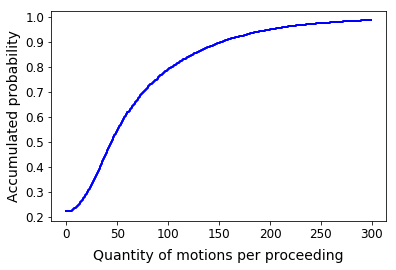

In [23]:
plt.step(dist1[:,0],dist1[:,1],color='blue', linewidth=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Accumulated probability', size=14)
plt.xlabel('Quantity of motions per proceeding', fontsize=14, labelpad=8)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("plots/dist_mov.png", facecolor='white', dpi=100)
plt.show()

Let's evaluate the distribution of tokens quantities per motion.

In [20]:
leng=[]
for i in range(len(mov)):
    for j in range(len(mov[i])):
        leng.append(np.shape(tokens2matrix(tokenize(mov[i][j][1])))[0])

In [21]:
dist=[]
leng=np.array(leng)

for i in range(75):
    dist.append([i,np.mean(leng<=i)])
    
dist=np.array(dist)

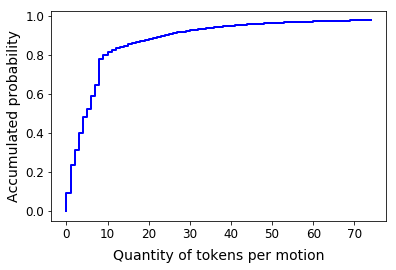

In [22]:
plt.step(dist[:,0],dist[:,1],color='blue', linewidth=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Accumulated probability', fontsize=14)
plt.xlabel('Quantity of tokens per motion', fontsize=14, labelpad=8)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("plots/dist_token.png", facecolor='white', dpi=100)
plt.show()

You can see that over 90% of motions have 30 tokens or less. In our application we will keep the first 30 tokens of each move.

Defining function that will help us get the X and y bases used for learning.

In [24]:
def get_X_y(mov,tags,l1=5,l2=30):
    
    #l1: let's take the last l1 motions in each proceeding
    #l2: let's take the first l2 tokens in each motion
    
    #indexes of valid legal proceedings (with motions and tags)
    index=[]
    for i in range(len(mov)):
        if 0<len(mov[i]) and tags[i]!="": index.append(i) 
        else: pass

    print("Number of valid proceedings (with motions and tags):",len(index),"\n")

    #organizing motions in X and tags in y
    X=np.zeros((len(index),l1,l2,embed_dim))
    y=[]
    cont=0
    
    #get numerical X embedding the tokens from those motions (from valid proceedings):
    for i in index:
        temp=[]
        y.append(tags[i])

        mov[i]=mov[i][-l1::] #let's take the last l1 motions in each proceeding

        for j in range(len(mov[i])):

            if in_vocab(mov[i][j][1]):  #if there is at least one word in the vocabulary
                temp=tokens2matrix(tokenize(mov[i][j][1])[:l2]) #let's take the first l2 tokens in each motion and turn them into a matrix l2x100
                X[cont][j][:np.shape(temp)[0]]=temp
            else: pass


        #counter
        cont+=1
        if cont%int(len(index)/5)==0: print(round(100*cont/len(index),0),"% concluded")
        else: pass
        
    return X,y

In [25]:
l1=5 #vamos pegar somente as últimas l1 movimentações
l2=30 #vamos pegar somente os primeiros l2 tokens de cada movimentação

X,y=get_X_y(mov,tags,l1,l2)

Number of valid proceedings (with motions and tags): 6449 

20.0 % concluded
40.0 % concluded
60.0 % concluded
80.0 % concluded
100.0 % concluded


Y Distribution

In [26]:
print('H:Arquivado',np.sum(np.array(y)=='H:Arquivado'),np.mean(np.array(y)=='H:Arquivado'), '\n')
print('H:Ativo',np.sum(np.array(y)=='H:Ativo'),np.mean(np.array(y)=='H:Ativo'), '\n')
print('H:Suspenso',np.sum(np.array(y)=='H:Suspenso'),np.mean(np.array(y)=='H:Suspenso'), '\n')

H:Arquivado 3040 0.4713909133198946 

H:Ativo 2917 0.45231818886649094 

H:Suspenso 492 0.07629089781361452 



Latex table of Y distribution:

In [27]:
print("\\begin{table}[H] \n",
      "\centering \n",
      "\caption{Distribution of legal proceedings' labels} \n",
      ' \\begin{tabular}{c|c|c} \n',
      ' \\toprule \n',
      '        & \% & N\\\ \n',
      ' \midrule \n',
      ' Archived (class 1) &'+str(np.round(100*np.mean(np.array(y)=='H:Arquivado'),2))+'\%'+' & '+str(np.sum(np.array(y)=='H:Arquivado'))+'\\\ \n',
      ' Active (class 2) &'+str(np.round(100*np.mean(np.array(y)=='H:Ativo'),2))+'\%'+' & '+str(np.sum(np.array(y)=='H:Ativo'))+'\\\ \n',
      ' Suspended (class 3) &'+str(np.round(100*np.mean(np.array(y)=='H:Suspenso'),2))+'\%'+' & '+str(np.sum(np.array(y)=='H:Suspenso'))+'\\\ \n',
      ' \midrule \n',
      ' Total &'+str(100)+'\%'+' & '+str(len(y))+'\\\ \n',
      ' \\bottomrule \n',
      ' \end{tabular}% \n',
      '\label{tab:lab}% \n',
   '\end{table}% \n')

\begin{table}[H] 
 \centering 
 \caption{Distribution of legal proceedings' labels} 
  \begin{tabular}{c|c|c} 
  \toprule 
         & \% & N\\ 
  \midrule 
  Archived (class 1) &47.14\% & 3040\\ 
  Active (class 2) &45.23\% & 2917\\ 
  Suspended (class 3) &7.63\% & 492\\ 
  \midrule 
  Total &100\% & 6449\\ 
  \bottomrule 
  \end{tabular}% 
 \label{tab:lab}% 
 \end{table}% 



Turning y into numeric:

In [28]:
encode={'H:Arquivado': 1,'H:Ativo': 2,'H:Suspenso': 3}
decode={1:'H:Arquivado',2:'H:Ativo',3:'H:Suspenso'}
#
for i in range(len(y)):
    y[i]=encode[y[i]]

Splitting the dataset in train, test and validation set:

In [29]:
y=np.array(y)
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=2/3, random_state=22)
#
y_train2=np.array(pd.get_dummies(y_train))
y_val2=np.array(pd.get_dummies(y_val))
y_test2=np.array(pd.get_dummies(y_test))

np.shape(X_train),np.shape(y_train)

((4514, 5, 30, 100), (4514,))

In [30]:
n_train=len(y_train)
n_val=len(y_val)
n_test=len(y_test)
n=n_train+n_val+n_test

print("\\begin{table}[H] \n",
      "\centering \n",
      "\caption{Training, validation and test sets} \n",
      ' \\begin{tabular}{c|c|c} \n',
      ' \\toprule \n',
      '        & \% & N\\\ \n',
      ' \midrule \n',
      ' Training set &'+str(np.round(100*(n_train/n),2))+'\%'+' & '+str(n_train)+'\\\ \n',
      ' Validation set &'+str(np.round(100*(n_val/n),2))+'\%'+' & '+str(n_val)+'\\\ \n',
      ' Test set &'+str(np.round(100*(n_test/n),2))+'\%'+' & '+str(n_test)+'\\\ \n',
      ' \midrule \n',
      ' Total &'+str(100)+'\%'+' & '+str(len(y))+'\\\ \n',
      ' \\bottomrule \n',
      ' \end{tabular}% \n',
      '\label{tab:lab}% \n',
   '\end{table}% \n')    

\begin{table}[H] 
 \centering 
 \caption{Training, validation and test sets} 
  \begin{tabular}{c|c|c} 
  \toprule 
         & \% & N\\ 
  \midrule 
  Training set &70.0\% & 4514\\ 
  Validation set &10.0\% & 645\\ 
  Test set &20.0\% & 1290\\ 
  \midrule 
  Total &100\% & 6449\\ 
  \bottomrule 
  \end{tabular}% 
 \label{tab:lab}% 
 \end{table}% 



### Tuning classification model

Grid

In [29]:
def expand_grid(dictionary):
       return pd.DataFrame([row for row in product(*dictionary.values())], 
                           columns=dictionary.keys())

hyper = {'ks': [1,2,3,4,6,8,10], #kernels
         'neurons': [10,20,30,40,50,75,100], #hidden LSTM
         'lambdas': [.0,.001,.01,.1], #regularization
         'score': [0], 
         'lower_ci': [0], 
         'upper_ci': [0]}

hyper=expand_grid(hyper)
hyper=hyper[['ks','neurons','lambdas','score','lower_ci','upper_ci']]

np.shape(hyper)

(196, 6)

Search

In [32]:
start_time = time.time()

num_classes = 3

for i in range(np.shape(hyper)[0]):
    
    k=hyper.loc[i,'ks'] 
    neuron=hyper.loc[i,'neurons'] 
    lamb=hyper.loc[i,'lambdas'] 
    
    seed(42)
    set_random_seed(42)

    ### model for features extraction
    inputs = Input(shape=np.shape(X_train)[1:])
    conv = TimeDistributed(Conv1D(k, 1, activation='relu',kernel_constraint=unit_norm(axis=1), use_bias=False))(inputs)
    pool = TimeDistributed(GlobalMaxPooling1D())(conv)
    #
    model_feat = Model(inputs, pool)

    ### model for classification
    pooled_inputs = Input(shape=(5, k))
    lstm = LSTM(neuron, kernel_regularizer=l2(lamb))(pooled_inputs)
    soft = Dense(num_classes, activation='softmax')(lstm)
    #
    model_classific = Model(pooled_inputs, soft)

    ### final model
    outputs = model_classific(model_feat(inputs))
    model = Model(inputs, outputs)

    #compiling
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    #Running
    seed(42)
    set_random_seed(42)

    modelo=model.fit(X_train, y_train2, epochs=200,
                                              batch_size=500,
                                              shuffle=True,
                                              verbose=False,
                                              validation_data=(X_val, y_val2))
    
    p=modelo.history['val_acc'][-1]
    hyper.loc[i,'score']=p
    hyper.loc[i,'lower_ci']=p-1.96*np.sqrt((p*(1-p)/np.shape(y_val)[0]))
    hyper.loc[i,'upper_ci']=p+1.96*np.sqrt((p*(1-p)/np.shape(y_val)[0]))
   
    #progress
    if i%int(np.shape(hyper)[0]/10)==0: print(round(100*i/np.shape(hyper)[0],0),"% concluded in", np.round((time.time() - start_time)/60,2),"minutes")
    else: pass

W0126 18:57:16.628088 140220856276736 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0126 18:57:16.649991 140220856276736 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0126 18:57:17.264739 140220856276736 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0126 18:57:18.061628 140220856276736 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated

0.0 % concluded in 2.47 minutes
10.0 % concluded in 39.98 minutes
19.0 % concluded in 78.7 minutes
29.0 % concluded in 120.48 minutes
39.0 % concluded in 164.77 minutes
48.0 % concluded in 211.73 minutes
58.0 % concluded in 255.37 minutes
68.0 % concluded in 301.37 minutes
78.0 % concluded in 346.46 minutes
87.0 % concluded in 392.95 minutes
97.0 % concluded in 447.27 minutes


In [35]:
hyper.iloc[np.argsort(hyper.loc[:,'score']),:].tail(30)

,ks,neurons,lambdas,score,lower_ci,upper_ci
34,10,20,0.000,0.931783,0.912326,0.951240
180,8,100,0.001,0.931783,0.912326,0.951240
188,10,100,0.010,0.931783,0.912326,0.951240
159,8,75,0.010,0.931783,0.912326,0.951240
181,10,100,0.001,0.931783,0.912326,0.951240
41,10,20,0.001,0.933333,0.914082,0.952584
48,10,20,0.010,0.933333,0.914082,0.952584
95,6,40,0.001,0.933333,0.914083,0.952584
37,3,20,0.001,0.933333,0.914083,0.952584
47,8,20,0.010,0.934884,0.915842,0.953925


### Running classification model

Number of CNN filters (kernels):

In [31]:
k=3

Training final model:

In [37]:
num_classes = 3
neuron=20

seed(42)
set_random_seed(42)

### model for features extraction
inputs = Input(shape=np.shape(X_train)[1:])
conv = TimeDistributed(Conv1D(k, 1, activation='relu',kernel_constraint=unit_norm(axis=1), use_bias=False))(inputs)
pool = TimeDistributed(GlobalMaxPooling1D())(conv)
#
model_feat = Model(inputs, pool)
model_feat.summary()
print('\n')

### model for classification
pooled_inputs = Input(shape=(5, k))
lstm = LSTM(neuron, kernel_regularizer=l2(.001))(pooled_inputs)
soft = Dense(num_classes, activation='softmax')(lstm)
#
model_classific = Model(pooled_inputs, soft)
model_classific.summary()
print('\n')

### final model
outputs = model_classific(model_feat(inputs))
model = Model(inputs, outputs)
model.summary()

#compiling
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5, 30, 100)        0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5, 30, 3)          300       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 3)              0         
Total params: 300
Trainable params: 300
Non-trainable params: 0
_________________________________________________________________




W0127 07:36:00.334395 140692720502528 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 5, 3)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                1920      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 63        
Total params: 1,983
Trainable params: 1,983
Non-trainable params: 0
_________________________________________________________________


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5, 30, 100)        0         
_________________________________________________________________
model_2 (Model)              (None, 5, 3)              300       
_________________________________________________________________
model_

In [38]:
seed(42)
set_random_seed(42)

modelo=model.fit(X_train, y_train2, epochs=200,
                                          batch_size=500,
                                          shuffle=True,
                                          verbose=False,
                                          validation_data=(X_val, y_val2))

W0127 07:36:01.370428 140692720502528 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Saving neural network weights:

In [39]:
model.save('modelos/model_paper_status.h5') 
model_feat.save('modelos/model_feat_paper_status.h5') 
model_classific.save('modelos/model_classific_paper_status.h5') 

### Model evaluation

Accuracy plotting:

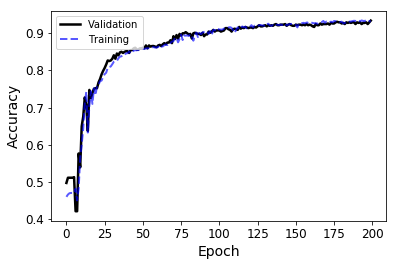

In [40]:
#Plotando dados de treino
plt.plot(modelo.history['val_acc'], 'k-', linewidth=2.5)
plt.plot(modelo.history['acc'],'b--', linewidth=2, alpha=.65)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Validation', 'Training'], loc='upper left')
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("plots/acuracia.png", facecolor='white', dpi=100)
plt.show()

Accuracy and confusion matrix in test set

Accuracy test set=0.92 +- 0.02 

0.9003260452874029 0.9306817066505817


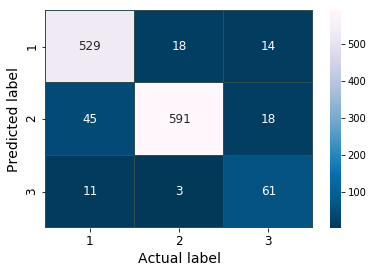

In [41]:
#Accuracy
probs_y=model.predict(X_test)
y_pred=np.argmax(probs_y,axis=1)
y_real=np.argmax(y_test2,axis=1)
p=np.mean(y_pred==y_real)
print("Accuracy test set=%3.2f" % p ,"+-", np.round(1.96*np.sqrt((p*(1-p)/np.shape(y_pred)[0])),2), "\n")
print(p-1.96*np.sqrt((p*(1-p)/np.shape(y_pred)[0])),p+1.96*np.sqrt((p*(1-p)/np.shape(y_pred)[0])))

#Matrix
x_axis_labels = ['1', '2', '3'] # labels for x-axis
y_axis_labels = [1,2,3] # labels for y-axis

conf=confusion_matrix(y_pred,y_real) #/np.sum(confusion_matrix(y_pred,y_real))
ax = sns.heatmap(conf, annot=True, linecolor='darkslategrey', fmt="g", xticklabels=x_axis_labels, yticklabels=y_axis_labels,
                 annot_kws={"fontsize":12}, linewidths=.1, cmap="PuBu_r") #fmt=".2%", , cmap="Greys" 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylabel('Predicted label', size=14)
plt.xlabel('Actual label', size=14)
plt.savefig("plots/conf.png", facecolor='white', dpi=300)
plt.show()

##### Metrics by class:

In [42]:
report=classification_report(y_real, y_pred, labels=[0, 1, 2], output_dict=True)

Defining confidence interval for the three classes:

In [43]:
##### PRECISION #####

n=np.sum(conf,axis=1)

### Class 0 ###
c=0
p_prec_0=conf[c,c]/n[c]

# Bootstrap #
samp=np.hstack((np.ones(conf[c,c]), np.zeros(n[c]-conf[c,c])))
dist_prec_0=[np.mean(np.random.choice(samp, n[c])) for i in range(10000)]
er_prec_0=np.round(((np.mean(dist_prec_0)-np.percentile(dist_prec_0, 2.5))+(np.percentile(dist_prec_0, 97.5)-np.mean(dist_prec_0)))/2,2)


### Class 1 ###
c=1
p_prec_1=conf[c,c]/n[c]

# Bootstrap #
samp=np.hstack((np.ones(conf[c,c]), np.zeros(n[c]-conf[c,c])))
dist_prec_1=[np.mean(np.random.choice(samp, n[c])) for i in range(10000)]
er_prec_1=np.round(((np.mean(dist_prec_1)-np.percentile(dist_prec_1, 2.5))+(np.percentile(dist_prec_1, 97.5)-np.mean(dist_prec_1)))/2,2)


### Class 2 ###
c=2
p_prec_2=conf[c,c]/n[c]

# Bootstrap #
samp=np.hstack((np.ones(conf[c,c]), np.zeros(n[c]-conf[c,c])))
dist_prec_2=[np.mean(np.random.choice(samp, n[c])) for i in range(10000)]
er_prec_2=np.round(((np.mean(dist_prec_2)-np.percentile(dist_prec_2, 2.5))+(np.percentile(dist_prec_2, 97.5)-np.mean(dist_prec_2)))/2,2)

In [44]:
er_prec_0, er_prec_1, er_prec_2 #errors

(0.02, 0.02, 0.09)

In [45]:
#RECALL

n=np.sum(conf,axis=0)

### Class 0 ###
c=0
p_rec_0=conf[c,c]/n[c]

# Bootstrap #
samp=np.hstack((np.ones(conf[c,c]), np.zeros(n[c]-conf[c,c])))
dist_rec_0=[np.mean(np.random.choice(samp, n[c])) for i in range(10000)]
er_rec_0=np.round(((np.mean(dist_rec_0)-np.percentile(dist_rec_0, 2.5))+(np.percentile(dist_rec_0, 97.5)-np.mean(dist_rec_0)))/2,2)


### Class 1 ###
c=1
p_rec_1=conf[c,c]/n[c]

# Bootstrap #
samp=np.hstack((np.ones(conf[c,c]), np.zeros(n[c]-conf[c,c])))
dist_rec_1=[np.mean(np.random.choice(samp, n[c])) for i in range(10000)]
er_rec_1=np.round(((np.mean(dist_rec_1)-np.percentile(dist_rec_1, 2.5))+(np.percentile(dist_rec_1, 97.5)-np.mean(dist_rec_1)))/2,2)


### Class 2 ###
c=2
p_rec_2=conf[c,c]/n[c]

# Bootstrap #
samp=np.hstack((np.ones(conf[c,c]), np.zeros(n[c]-conf[c,c])))
dist_rec_2=[np.mean(np.random.choice(samp, n[c])) for i in range(10000)]
er_rec_2=np.round(((np.mean(dist_rec_2)-np.percentile(dist_rec_2, 2.5))+(np.percentile(dist_rec_2, 97.5)-np.mean(dist_rec_2)))/2,2)

In [46]:
er_rec_0, er_rec_1, er_rec_2 #errors

(0.02, 0.01, 0.1)

In [47]:
#F1

def f1(prec, rec):
    return(2*(prec*rec)/(prec+rec))

### Class 0 ###
dist_f1_0=f1(np.array(dist_prec_0), np.array(dist_rec_0))
er_f1_0=np.round(((np.mean(dist_f1_0)-np.percentile(dist_f1_0, 2.5))+(np.percentile(dist_f1_0, 97.5)-np.mean(dist_f1_0)))/2,2)

### Class 1 ###
dist_f1_1=f1(np.array(dist_prec_1), np.array(dist_rec_1))
er_f1_1=np.round(((np.mean(dist_f1_1)-np.percentile(dist_f1_1, 2.5))+(np.percentile(dist_f1_1, 97.5)-np.mean(dist_f1_1)))/2,2)

### Class 2 ###
dist_f1_2=f1(np.array(dist_prec_2), np.array(dist_rec_2))
er_f1_2=np.round(((np.mean(dist_f1_2)-np.percentile(dist_f1_2, 2.5))+(np.percentile(dist_f1_2, 97.5)-np.mean(dist_f1_2)))/2,2)

In [48]:
er_f1_0,er_f1_1,er_f1_2 #errors

(0.02, 0.01, 0.07)

Latex table

In [49]:
lista=[]
for i in range(num_classes):
    lista.append([np.round(report[str(i)]['f1-score'],2),np.round(report[str(i)]['precision'],2),np.round(report[str(i)]['recall'],2),np.round(report[str(i)]['support'],2)])
    
print("\\begin{table}[H] \n",
      "\centering \n",
      '\caption{Evaluation metrics by class} \n',
      ' \\begin{tabular}{c|c|c|c|c} \n',
      ' \\toprule \n',
      '       & F1 Score & Precision & Recall & N\\\ \n',
      ' \midrule \n',
      ' Archived (class 1) &'+str(lista[0][0])+' \pm '+str(er_f1_0)+'&'+str(lista[0][1])+' \pm '+str(er_prec_0)+'&'+str(lista[0][2])+' \pm '+str(er_rec_0)+'&'+str(lista[0][3])+'\\\ \n',
      ' Active (class 2) &'+str(lista[1][0])+' \pm '+str(er_f1_1)+'&'+str(lista[1][1])+' \pm '+str(er_prec_1)+'&'+str(lista[1][2])+' \pm '+str(er_rec_1)+'&'+str(lista[1][3])+'\\\ \n',
      ' Suspended (class 3) &'+str(lista[2][0])+' \pm '+str(er_f1_2)+'&'+str(lista[2][1])+' \pm '+str(er_prec_2)+'&'+str(lista[2][2])+' \pm '+str(er_rec_2)+'&'+str(lista[2][3])+'\\\ \n',
      ' \\bottomrule \n',
      ' \end{tabular}% \n',
      '\label{tab:lab}% \n',
   '\end{table}% \n')

\begin{table}[H] 
 \centering 
 \caption{Evaluation metrics by class} 
  \begin{tabular}{c|c|c|c|c} 
  \toprule 
        & F1 Score & Precision & Recall & N\\ 
  \midrule 
  Archived (class 1) &0.92 \pm 0.02&0.94 \pm 0.02&0.9 \pm 0.02&585\\ 
  Active (class 2) &0.93 \pm 0.01&0.9 \pm 0.02&0.97 \pm 0.01&612\\ 
  Suspended (class 3) &0.73 \pm 0.07&0.81 \pm 0.09&0.66 \pm 0.1&93\\ 
  \bottomrule 
  \end{tabular}% 
 \label{tab:lab}% 
 \end{table}% 



##### Overall metrics:

In [50]:
##### PRECISION #####

n=np.sum(conf,axis=0)

### Macro ###
dist_prec_macro=(np.array(dist_prec_0)+np.array(dist_prec_1)+np.array(dist_prec_2))/3
er_prec_macro=np.round(((np.mean(dist_prec_macro)-np.percentile(dist_prec_macro, 2.5))+(np.percentile(dist_prec_macro, 97.5)-np.mean(dist_prec_macro)))/2,2)

### Micro ###
dist_prec_micro=(np.array(dist_prec_0)*n[0]+np.array(dist_prec_1)*n[1]+np.array(dist_prec_2)*n[2])/np.sum(n)
er_prec_micro=np.round(((np.mean(dist_prec_micro)-np.percentile(dist_prec_micro, 2.5))+(np.percentile(dist_prec_micro, 97.5)-np.mean(dist_prec_micro)))/2,2)

In [51]:
er_prec_macro, er_prec_micro #errors

(0.03, 0.01)

In [52]:
##### RECALL #####

n=np.sum(conf,axis=0)

### Macro ###
dist_rec_macro=(np.array(dist_rec_0)+np.array(dist_rec_1)+np.array(dist_rec_2))/3
er_rec_macro=np.round(((np.mean(dist_rec_macro)-np.percentile(dist_rec_macro, 2.5))+(np.percentile(dist_rec_macro, 97.5)-np.mean(dist_rec_macro)))/2,2)

### Micro ###
dist_rec_micro=(np.array(dist_rec_0)*n[0]+np.array(dist_rec_1)*n[1]+np.array(dist_rec_2)*n[2])/np.sum(n)
er_rec_micro=np.round(((np.mean(dist_rec_micro)-np.percentile(dist_rec_micro, 2.5))+(np.percentile(dist_rec_micro, 97.5)-np.mean(dist_rec_micro)))/2,2)

In [53]:
er_rec_macro, er_rec_micro #errors

(0.03, 0.01)

In [54]:
##### F1 #####

n=np.sum(conf,axis=0)

### Macro ###
dist_f1_macro=(np.array(dist_f1_0)+np.array(dist_f1_1)+np.array(dist_f1_2))/3
er_f1_macro=np.round(((np.mean(dist_f1_macro)-np.percentile(dist_f1_macro, 2.5))+(np.percentile(dist_f1_macro, 97.5)-np.mean(dist_f1_macro)))/2,2)

### Micro ###
dist_f1_micro=(np.array(dist_f1_0)*n[0]+np.array(dist_f1_1)*n[1]+np.array(dist_f1_2)*n[2])/np.sum(n)
er_f1_micro=np.round(((np.mean(dist_f1_micro)-np.percentile(dist_f1_micro, 2.5))+(np.percentile(dist_f1_micro, 97.5)-np.mean(dist_f1_micro)))/2,2)

In [55]:
er_f1_macro,er_f1_micro #errors

(0.02, 0.01)

Latex table

In [56]:
lista=[]
for i in ['macro avg','weighted avg']:
    lista.append([np.round(report[str(i)]['f1-score'],2),np.round(report[str(i)]['precision'],2),np.round(report[str(i)]['recall'],2),np.round(report[str(i)]['support'],2)])
    
print("\\begin{table}[H] \n",
      "\centering \n",
      '\caption{Aggregate analysis of evaluation metrics} \n',
      ' \\begin{tabular}{c|c|c|c|c} \n',
      ' \\toprule \n',
      '        & F1 Score & Precision & Recall & N\\\ \n',
      ' \midrule \n',
      ' Simple average &'+str(lista[0][0])+' \pm '+str(er_f1_macro)+'&'+str(lista[0][1])+' \pm '+str(er_prec_macro)+'&'+str(lista[0][2])+' \pm '+str(er_rec_macro)+'&'+str(lista[0][3])+'\\\ \n',
      ' Weighted average &'+str(lista[1][0])+' \pm '+str(er_f1_micro)+'&'+str(lista[1][1])+' \pm '+str(er_prec_micro)+'&'+str(lista[1][2])+' \pm '+str(er_rec_micro)+'&'+str(lista[1][3])+'\\\ \n',
      ' \\bottomrule \n',
      ' \end{tabular}% \n',
      '\label{tab:lab}% \n',
   '\end{table}% \n')

\begin{table}[H] 
 \centering 
 \caption{Aggregate analysis of evaluation metrics} 
  \begin{tabular}{c|c|c|c|c} 
  \toprule 
         & F1 Score & Precision & Recall & N\\ 
  \midrule 
  Simple average &0.86 \pm 0.02&0.89 \pm 0.03&0.84 \pm 0.03&1290\\ 
  Weighted average &0.91 \pm 0.01&0.91 \pm 0.01&0.92 \pm 0.01&1290\\ 
  \bottomrule 
  \end{tabular}% 
 \label{tab:lab}% 
 \end{table}% 



# Interpretability

### What are the filters looking for?

Grabbing filters weights:

In [57]:
w=model.layers[1].get_weights()
np.shape(w)

(1, 1, 100, 3)

Number of terms closest to the filters we're going to take from vocabulary:

In [58]:
n_w=5

Table:

In [59]:
for n in range(k):
    v=np.reshape(w[0][:,:,n],-1)

    print("%Filter",n+1,"\n")
    
    for i in word.wv.similar_by_vector(v,n_w):
         print(i[0].replace("_", " "),np.round(i[1],2))
    
    print("\n\n")

%Filter 1 

embargada 0.52
embargos declaracao opostos 0.49
acolho-os 0.49
embargante 0.48
entendimento exarado 0.48



%Filter 2 

baixa definitiva 0.54
arquivado definitivamente 0.53
atraves grerj 0.44
veiculo alienado fiduciariamente 0.39
juridica apta determinar 0.39



%Filter 3 

arquivado definitivamente 0.52
arquivado 0.5
feitos nao reativados 0.48
arquivado provisoriamente 0.47
arquivo geral 0.47





Latex table:

In [60]:
print('\\begin{table}[H] \n',
      '\centering \n',
      '\\begin{threeparttable} \n',
      '\caption{Similarity between most similar tokens and filters} \n',
        '\\begin{tabular}{c|c|c} \n',
        '\\toprule \n',
     '\multicolumn{1}{c|}{} & \multicolumn{1}{c|}{Tokens} & \multicolumn{1}{c}{Cosine similarity}\\\\ \n')

for n in range(k):
    print('\midrule')
    v=np.reshape(w[0][:,:,n],-1)
    print('\multicolumn{1}{c|}{\multirow{'+str(n_w)+'}[2]{*}{Filter '+str(n+1)+'}} &'+ "\ textit{".replace(" ", "")+word.wv.similar_by_vector(v,n_w)[0][0].replace("_", " ")+'} &'+ str(np.round(word.wv.similar_by_vector(v,n_w)[0][1],2)) +' \\\\')
    for j in range(n_w-1):
        print('\multicolumn{1}{c|}{} &'+ "\ textit{".replace(" ", "")+word.wv.similar_by_vector(v,n_w)[j+1][0].replace("_", " ")+'} &'+str(np.round(word.wv.similar_by_vector(v,n_w)[j+1][1],2))+' \\\\')


print('\n \\bottomrule \n',
        '\end{tabular} \n',
      '\label{tab:simil} \n',
     '\end{threeparttable} \n',
    '\end{table} \n')

\begin{table}[H] 
 \centering 
 \begin{threeparttable} 
 \caption{Similarity between most similar tokens and filters} 
 \begin{tabular}{c|c|c} 
 \toprule 
 \multicolumn{1}{c|}{} & \multicolumn{1}{c|}{Tokens} & \multicolumn{1}{c}{Cosine similarity}\\ 

\midrule
\multicolumn{1}{c|}{\multirow{5}[2]{*}{Filter 1}} &\textit{embargada} &0.52 \\
\multicolumn{1}{c|}{} &\textit{embargos declaracao opostos} &0.49 \\
\multicolumn{1}{c|}{} &\textit{acolho-os} &0.49 \\
\multicolumn{1}{c|}{} &\textit{embargante} &0.48 \\
\multicolumn{1}{c|}{} &\textit{entendimento exarado} &0.48 \\
\midrule
\multicolumn{1}{c|}{\multirow{5}[2]{*}{Filter 2}} &\textit{baixa definitiva} &0.54 \\
\multicolumn{1}{c|}{} &\textit{arquivado definitivamente} &0.53 \\
\multicolumn{1}{c|}{} &\textit{atraves grerj} &0.44 \\
\multicolumn{1}{c|}{} &\textit{veiculo alienado fiduciariamente} &0.39 \\
\multicolumn{1}{c|}{} &\textit{juridica apta determinar} &0.39 \\
\midrule
\multicolumn{1}{c|}{\multirow{5}[2]{*}{Filter 3}} &\textit{a

### How do features extracted by each filter relate to classification?

In [61]:
rang=np.arange(0, .6, 0.01).tolist()

In [62]:
X_test_feat=model_feat.predict(X_test)

np.shape(X_test_feat)

(1290, 5, 3)

In [63]:
start_time = time.time()

kernels=list(range(k))
times=[0,1,2,3,4]

pdp={}
std={}

for kernel in kernels:
    
    pdp2={}
    std2={}
    
    for t in times:
        
        probs=[]
        stds=[]
        
        for i in rang:
            X_cf = copy.deepcopy(X_test_feat)
            X_cf[:,t, kernel]=i
            probs.append(np.mean(model_classific.predict(X_cf),axis=0).tolist())
            stds.append(np.std(model_classific.predict(X_cf),axis=0).tolist())
            
            
        pdp2[t]=np.array(probs)
        std2[t]=np.array(stds)
            
    pdp[kernel]=pdp2
    std[kernel]=std2

   
print((time.time() - start_time)/60,"minutos")

1.6041387955347697 minutos


In [64]:
for kernel in kernels:
    for t in times:
            
        pdp[kernel][t]-=pdp[kernel][t][0,:]

In [65]:
def pdp_plot(kernel, target, legend=True, legend2=1):

    plt.plot(rang,pdp[kernel][0][:,target-1],'y:', linewidth=3,label='t = -5')
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.plot(X_test_feat[:,0,kernel], [-.65]*np.shape(X_test_feat)[0], '|', color='y', markersize=18)
    er=1.96*std[kernel][0][:,target-1]/np.sqrt(np.shape(X_test_feat)[0])
    plt.fill_between(rang, pdp[kernel][0][:,target-1]+er, pdp[kernel][0][:,target-1]-er, facecolor='yellow', alpha=.2)

    plt.plot(rang,pdp[kernel][1][:,target-1],'c--', linewidth=2,label='t = -4')
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.plot(X_test_feat[:,1,kernel], [-.66]*np.shape(X_test_feat)[0], '|', color='c',  markersize=15)
    er=1.96*std[kernel][1][:,target-1]/np.sqrt(np.shape(X_test_feat)[0])
    plt.fill_between(rang, pdp[kernel][1][:,target-1]+er, pdp[kernel][1][:,target-1]-er, facecolor='cyan', alpha=.2)

    plt.plot(rang,pdp[kernel][2][:,target-1],'g-.', linewidth=2,label='t = -3')
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.plot(X_test_feat[:,2,kernel], [-.67]*np.shape(X_test_feat)[0], '|', color='g', markersize=12)
    er=1.96*std[kernel][2][:,target-1]/np.sqrt(np.shape(X_test_feat)[0])
    plt.fill_between(rang, pdp[kernel][2][:,target-1]+er, pdp[kernel][2][:,target-1]-er, facecolor='green', alpha=.2)

    plt.plot(rang,pdp[kernel][3][:,target-1],'b--', linewidth=2,label='t = -2')
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.plot(X_test_feat[:,3,kernel], [-.68]*np.shape(X_test_feat)[0], '|', color='b', markersize=9)
    er=1.96*std[kernel][3][:,target-1]/np.sqrt(np.shape(X_test_feat)[0])
    plt.fill_between(rang, pdp[kernel][3][:,target-1]+er, pdp[kernel][3][:,target-1]-er, facecolor='blue', alpha=.2)

    plt.plot(rang,pdp[kernel][4][:,target-1],'k', linewidth=2,label='t = -1')
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.plot(X_test_feat[:,4,kernel], [-.69]*np.shape(X_test_feat)[0], '|', color='k',  markersize=5)
    er=1.96*std[kernel][4][:,target-1]/np.sqrt(np.shape(X_test_feat)[0])
    plt.fill_between(rang, pdp[kernel][4][:,target-1]+er, pdp[kernel][4][:,target-1]-er, facecolor='black', alpha=.2)

    plt.ylim((-.7, .65))
    plt.xlim((0, .6))

    if legend: plt.gca().legend(loc='center left', bbox_to_anchor=(legend2, 0.5), fontsize=20)

    plt.title('Class '+ str(target), fontsize=19)
    plt.xlabel('Feature extracted by filter '+str(kernel+1), fontsize=17, labelpad=8)
    plt.ylabel('Average variation in prob.', fontsize=17)

    #plt.show()

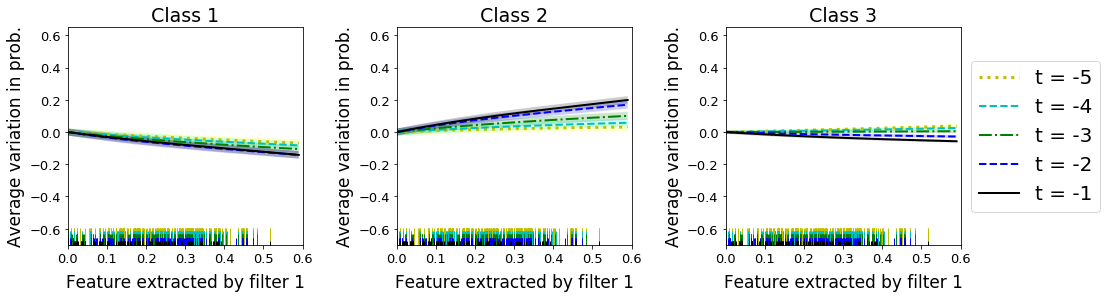

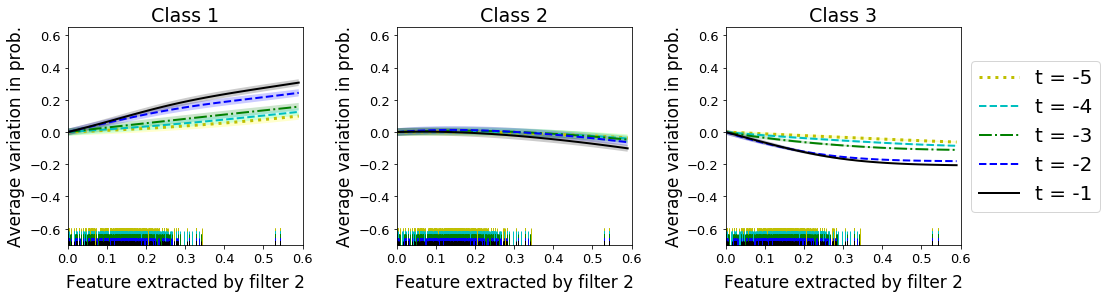

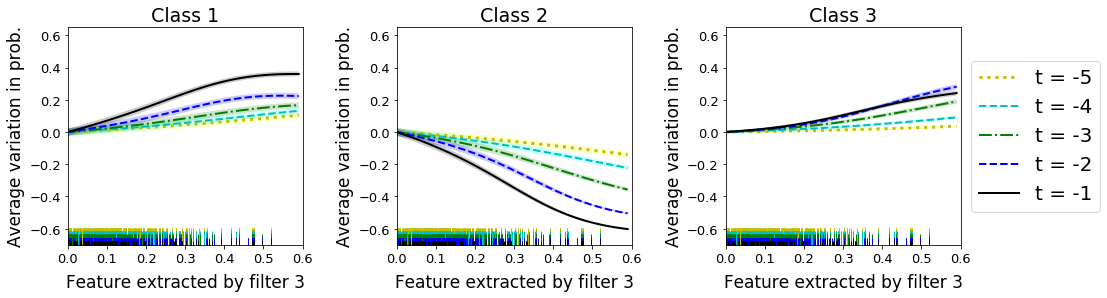

In [72]:
for kernel in kernels:
    plt.figure(figsize=(16,4))

    plt.subplot(1, 3, 1)
    target=1
    pdp_plot(kernel, target, legend=False)

    plt.subplot(1, 3, 2)
    target=2
    pdp_plot(kernel, target, legend=False)

    plt.subplot(1, 3, 3)
    target=3
    pdp_plot(kernel, target, legend=True)

    plt.subplots_adjust(hspace=.4, wspace=.4)

    plt.savefig("plots/pdp_kernel"+str(kernel+1)+".png", dpi=300,  bbox_inches='tight')

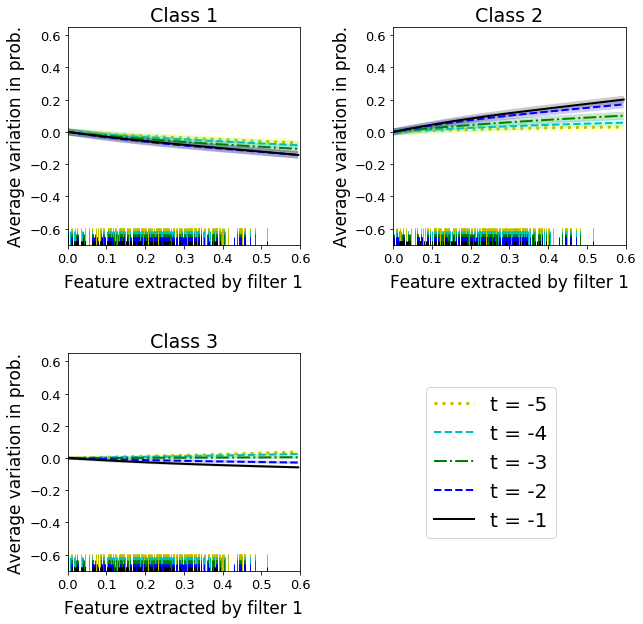

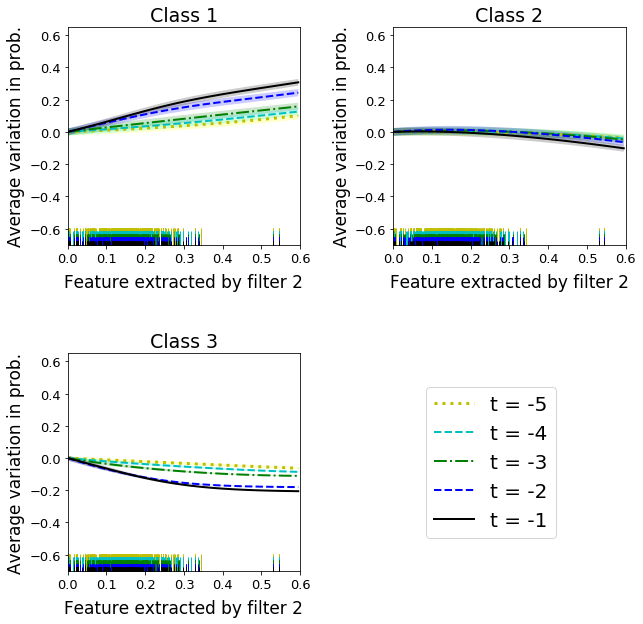

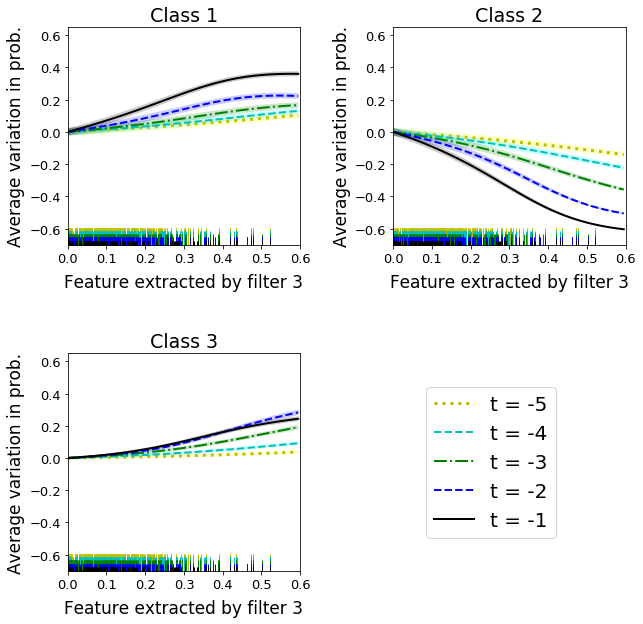

In [74]:
for kernel in kernels:
    plt.figure(figsize=(10,10))

    plt.subplot(2, 2, 1)
    target=1
    pdp_plot(kernel, target, legend=False)

    plt.subplot(2, 2, 2)
    target=2
    pdp_plot(kernel, target, legend=False)

    plt.subplot(2, 2, 3)
    target=3
    pdp_plot(kernel, target, legend=True, legend2=1.5)

    plt.subplots_adjust(hspace=.5, wspace=.4)

    plt.savefig("plots/pdp_kernel"+str(kernel+1)+"2.png", facecolor='white', dpi=300)